Design MERFISH probes using the example inputs from Jeff Moffitt. The original MATLAB design pipeline can be found at https://github.com/ZhuangLab/MERFISH_analysis.

# Download the input data
# This is for the UNIX-like operating systems. If you are using Windows, just download the files accordingly.
!mkdir temporary_data
!wget http://zhuang.harvard.edu/merfish/MERFISHData/MERFISH_Examples2.zip -O temporary_data/MERFISH_Examples2.zip
!unzip -o temporary_data/MERFISH_Examples2.zip -d temporary_data 
# Make a path for output
!mkdir temporary_data/MERFISH_Examples2/outputs

In [27]:
# Define all the input files you need in this script

import os

base_folder = r'\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries'
pool_folder = os.path.join(base_folder, 'CTP-10_Aire')
probe_folder = os.path.join(base_folder, r'CTP-10_Aire\MERFISH_designer\Aire_intronic_FISH')
output_folder = os.path.join(probe_folder, 'outputs')

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

codebook_file = os.path.join(probe_folder, 'design', r'codebook.csv')


genome_folder = os.path.join(base_folder, r'Genomes\mouse\GRCm39_ensembl')
transcripts_fasta_file = os.path.join(genome_folder, r'Mus_musculus.GRCm39.cdna.all.fa')
ncRNA_file = os.path.join(genome_folder, r'Mus_musculus.GRCm39.ncrna.fa')
fpkm_tracking_file = os.path.join(probe_folder, r'aire_wt_mtec_genes_ensembl.fpkm_tracking')

readout_fasta_file = os.path.join(probe_folder, r'readouts.fasta')

forward_primer_file = os.path.join(base_folder, r'Primers\forward_primers.fasta')
reverse_primer_file = os.path.join(base_folder, r'Primers\reverse_primers.fasta')

# Define the output files
ottable_transcriptome_file = os.path.join(output_folder, r'ottable_transcriptome.pkl')
selected_primers_file = os.path.join(output_folder, r'selected_primers.csv')
probe_output_file = os.path.join(output_folder, r'designed_probes.csv')
transcript_level_report_file = os.path.join(output_folder, r'transcript_level_report.csv')

In [3]:
print(transcripts_fasta_file)

\\10.245.74.212\Chromatin_NAS_2\Chromatin_Libraries\Genomes\mouse\GRCm39_ensembl\Mus_musculus.GRCm39.cdna.all.fa


# Initialize data structures

In [4]:
# Import the modules
import os
import sys
import pandas as pd

from IPython.display import display
import MERFISH_probe_design

import MERFISH_probe_design.IO.file_io as fio
import MERFISH_probe_design.probe_design.probe_dict as p_d
import MERFISH_probe_design.probe_design.OTTable_dict as ot
import MERFISH_probe_design.probe_design.readout_sequences as rs
import MERFISH_probe_design.probe_design.probe_selection as ps
import MERFISH_probe_design.probe_design.quality_check as qc
from MERFISH_probe_design.probe_design import filters
from MERFISH_probe_design.probe_design import plot
from MERFISH_probe_design.probe_design import primer_design

## load transcriptome

In [5]:
from importlib import reload
reload(fio)
reload(qc)

<module 'MERFISH_probe_design.probe_design.quality_check' from 'e:\\users\\puzheng\\documents\\merfish_probe_design\\MERFISH_probe_design\\probe_design\\quality_check.py'>

In [6]:
# Load the transcriptome as a pandas data frame
transcriptome = fio.load_transcriptome(transcripts_fasta_file, None)

Loaded 117486 transcripts.


In [7]:
def find_gene_id_in_description(description_string):
    import re
    return re.search(r'gene:([A-Za-z0-9\.]+)', description_string)[0].split('gene:')[1]
def find_gene_name_in_description(description_string):
    import re
    gene_matches = re.search(r'gene_symbol:([A-Za-z0-9\.]+)', description_string)
    if gene_matches is None:
        print(description_string)
        return float('nan')
    else:
        return gene_matches.group(0).split('gene_symbol:')[1]
        

In [8]:
transcriptome['gene_id'] = list(map(find_gene_id_in_description, transcriptome['description']))
transcriptome['gene_short_name'] = list(map(find_gene_name_in_description, transcriptome['description']))

ENSMUST00000166255.2 cdna chromosome:GRCm39:12:113618587:113618864:1 gene:ENSMUSG00000090395.2 gene_biotype:IG_LV_gene transcript_biotype:IG_LV_gene
ENSMUST00000095364.3 cdna chromosome:GRCm39:12:114594300:114594593:1 gene:ENSMUSG00000090765.2 gene_biotype:IG_LV_gene transcript_biotype:IG_LV_gene
ENSMUST00000179715.2 cdna scaffold:GRCm39:GL456212.1:31967:34932:-1 gene:ENSMUSG00000094915.2 gene_biotype:protein_coding transcript_biotype:protein_coding
ENSMUST00000180291.2 cdna scaffold:GRCm39:JH584298.1:90528:93623:1 gene:ENSMUSG00000094722.2 gene_biotype:protein_coding transcript_biotype:protein_coding
ENSMUST00000096862.5 cdna scaffold:GRCm39:GL456210.1:9124:58882:-1 gene:ENSMUSG00000079800.3 gene_biotype:protein_coding transcript_biotype:protein_coding
ENSMUST00000178291.2 cdna scaffold:GRCm39:GL456354.1:6366:8939:1 gene:ENSMUSG00000094741.2 gene_biotype:protein_coding transcript_biotype:protein_coding
ENSMUST00000178466.2 cdna scaffold:GRCm39:JH584296.1:41338:44417:-1 gene:ENSMUSG000

ENSMUST00000239500.1 cdna chromosome:GRCm39:7:141213373:141241641:-1 gene:ENSMUSG00000118661.1 gene_biotype:protein_coding transcript_biotype:protein_coding description:mucin 6, gastric [Source:NCBI gene (formerly Entrezgene);Acc:353328]
ENSMUST00000227806.2 cdna chromosome:GRCm39:2:136723191:136733309:-1 gene:ENSMUSG00000115423.3 gene_biotype:protein_coding transcript_biotype:protein_coding description:novel protein
ENSMUST00000231720.2 cdna chromosome:GRCm39:2:136727420:136727599:-1 gene:ENSMUSG00000116563.2 gene_biotype:protein_coding transcript_biotype:protein_coding description:novel protein
ENSMUST00000239171.2 cdna chromosome:GRCm39:5:24028285:24028576:-1 gene:ENSMUSG00000118636.2 gene_biotype:transcribed_unitary_pseudogene transcript_biotype:transcribed_unitary_pseudogene description:EF-hand calcium binding domain 10 (EFCAB10) pseudogene
ENSMUST00000205406.2 cdna chromosome:GRCm39:17:40158994:40159718:-1 gene:ENSMUSG00000118642.2 gene_biotype:pseudogene transcript_biotype:pseud

In [17]:
# Make sure that the transcriptome data frame has the standard column names.
# The standard columns are: transcript_id, sequence, gene_id, gene_short_name and FPKM.
# Also remove the non-standard columns for clarity.
transcriptome = qc.check_and_standardize_transcriptome(transcriptome, remove_non_standard_columns=True)
transcriptome # Let's have a look at what's inside the transcriptome

,transcript_id,sequence,FPKM,gene_id,gene_short_name
0,ENSMUST00000178537.2,GGGACAGGGGGC,1,ENSMUSG00000095668.2,Trbd1
1,ENSMUST00000178862.2,GGGACTGGGGGGGC,1,ENSMUSG00000094569.2,Trbd2
2,ENSMUST00000196221.2,ATGGCATAT,1,ENSMUSG00000096749.3,Trdd1
3,ENSMUST00000179664.2,ATGGCATATCA,1,ENSMUSG00000096749.3,Trdd1
4,ENSMUST00000177564.2,ATCGGAGGGATACGAG,1,ENSMUSG00000096176.2,Trdd2
...,...,...,...,...,...
117481,ENSMUST00000119049.2,CTGTTGACTCAGTTCTTTTTCTTTTATGCATTTGGAGTCACAGATA...,1,ENSMUSG00000068948.5,Olfr363
117482,ENSMUST00000122436.2,ATGTACAAAACTATGGGCAGCACACTGCTTCAACTGGCCATCTTTG...,1,ENSMUSG00000081580.2,Gm14129
117483,ENSMUST00000119835.2,GGCCTCGAAAAGGATCTCTTTCATCCCTCTACTGAGGAGAAGAGGA...,1,ENSMUSG00000084015.2,Gm14175
117484,ENSMUST00000122466.2,GTATAGCAAGGACCTAACCAAAGAGCGGGATGCCATCAAGCTGGAG...,1,ENSMUSG00000084184.2,Gm13474


In [18]:
# check wether this name exist
print(transcriptome['gene_id'][transcriptome['gene_short_name']=='Krt5'])
print(transcriptome['gene_id'][transcriptome['gene_short_name']=='Aire'])

51992    ENSMUSG00000061527.8
Name: gene_id, dtype: object
78927    ENSMUSG00000000731.16
78928    ENSMUSG00000000731.16
78929    ENSMUSG00000000731.16
78930    ENSMUSG00000000731.16
78931    ENSMUSG00000000731.16
78932    ENSMUSG00000000731.16
78933    ENSMUSG00000000731.16
78934    ENSMUSG00000000731.16
78935    ENSMUSG00000000731.16
78936    ENSMUSG00000000731.16
78937    ENSMUSG00000000731.16
78938    ENSMUSG00000000731.16
78939    ENSMUSG00000000731.16
78940    ENSMUSG00000000731.16
78941    ENSMUSG00000000731.16
78942    ENSMUSG00000000731.16
Name: gene_id, dtype: object


In [19]:
# Generate a codebook table for the target transcript
# Choose one of the full length protein coding transcript as the target
bit_names = ['RS0015', 'RS0083', 'RS0095', 'RS0109']

barcode_table = pd.DataFrame({'name':['Aire', 'Krt5'], 
                              'id':['ENSMUSG00000061527.8', 'ENSMUSG00000000731.16'], 
                              #'id':['ENSMUST00000023709.7', 'ENSMUST00000145975.8'], 
                              'barcode_str':['1100','0011']})
barcode_table

,name,id,barcode_str
0,Aire,ENSMUSG00000061527.8,1100
1,Krt5,ENSMUSG00000000731.16,0011


In [20]:
# Initialize the probe dictionary which is the carrier of the probes throught the design process.
probe_dict = p_d.init_probe_dict(['Aire', 'Krt5'], transcriptome, 
                                 'gene_short_name', K=30)
p_d.print_probe_dict(probe_dict)

Found 17 transcripts for 2 target genes.
Gene	Transcript	N_probes
Krt5
	ENSMUST00000023709.7	2168
Aire
	ENSMUST00000145975.8	1897
	ENSMUST00000130972.8	1894
	ENSMUST00000128241.8	1909
	ENSMUST00000143548.8	1236
	ENSMUST00000131028.8	2937
	ENSMUST00000155021.8	1708
	ENSMUST00000140636.8	1586
	ENSMUST00000148469.8	1589
	ENSMUST00000019257.15	1897
	ENSMUST00000105395.9	1601
	ENSMUST00000156417.8	1598
	ENSMUST00000105396.9	1720
	ENSMUST00000143735.8	1907
	ENSMUST00000154374.2	1683
	ENSMUST00000143452.2	603
	ENSMUST00000141255.2	1048


In [15]:
# Select the transcripts that we want to target
# The target transcripts are already defined in the codebook
probe_dict = p_d.select_transcripts_by_ids(probe_dict, 
                                           transcript_ids=['ENSMUST00000023709.7', 'ENSMUST00000145975.8'])
p_d.print_probe_dict(probe_dict) # We excluded all the transcripts that are not our direct targets

Gene	Transcript	N_probes
Krt5
	ENSMUST00000023709.7	2168
Aire
	ENSMUST00000145975.8	1897


In [26]:
probe_dict['Krt5']['ENSMUST00000023709.7']

,gene_id,transcript_id,shift,target_sequence
0,Krt5,ENSMUST00000023709.7,0,CACCCACAGCGTCCTGTTGAACGCCGCTGA
1,Krt5,ENSMUST00000023709.7,1,ACCCACAGCGTCCTGTTGAACGCCGCTGAC
2,Krt5,ENSMUST00000023709.7,2,CCCACAGCGTCCTGTTGAACGCCGCTGACC
3,Krt5,ENSMUST00000023709.7,3,CCACAGCGTCCTGTTGAACGCCGCTGACCT
4,Krt5,ENSMUST00000023709.7,4,CACAGCGTCCTGTTGAACGCCGCTGACCTC
...,...,...,...,...
2163,Krt5,ENSMUST00000023709.7,2163,CCAGAGTCTGTCCAATAAAATGCTTTTATA
2164,Krt5,ENSMUST00000023709.7,2164,CAGAGTCTGTCCAATAAAATGCTTTTATAA
2165,Krt5,ENSMUST00000023709.7,2165,AGAGTCTGTCCAATAAAATGCTTTTATAAT
2166,Krt5,ENSMUST00000023709.7,2166,GAGTCTGTCCAATAAAATGCTTTTATAATA


In [16]:
# Initialize the off-target counting tables
# OTTable for rRNA/tRNAs
ncRNAs =  fio.load_fasta_into_df(ncRNA_file)
ottable_rtRNAs = ot.get_OTTable_for_rtRNAs(ncRNAs, 15)

Found 378 rRNAs/tRNAs from 21659 non-coding RNAs.


In [21]:
# OTTables for the genes we target
gene_ottable_dict = ot.get_gene_OTTables(transcriptome, ['Aire', 'Krt5'], 'gene_short_name', 17)

Generate OTTable for gene Aire.
Construct a OTTable using 16/16 transcripts with FPKM > 0.
Generate OTTable for gene Krt5.
Construct a OTTable using 1/1 transcripts with FPKM > 0.


In [22]:
%%time
# OTTable for the transcriptome.
ottable_transcriptome = ot.get_OTTable_for_transcriptome(transcriptome, 17)

Construct a OTTable using 117486/117486 transcripts with FPKM > 0.
Processed 10000/117486 sequences.
Processed 20000/117486 sequences.
Processed 30000/117486 sequences.
Processed 40000/117486 sequences.
Processed 50000/117486 sequences.
Processed 60000/117486 sequences.
Processed 70000/117486 sequences.
Processed 80000/117486 sequences.
Processed 90000/117486 sequences.
Processed 100000/117486 sequences.
Processed 110000/117486 sequences.
Wall time: 2min 46s


# Select target regions

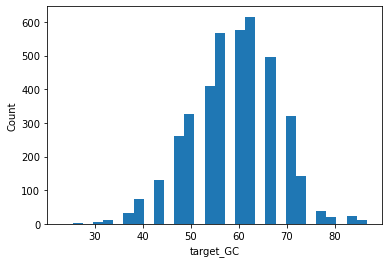

In [37]:
# Calculate and plot the GC contents of the target regions
filters.calc_gc_for_probe_dict(probe_dict, column_key_seq='target_sequence', column_key_write='target_GC')
plot.plot_hist(probe_dict, column_key='target_GC')

Krt5
	ENSMUST00000023709.7: 2001 / 2168 probes passed the filter 43 < target_GC <  73.
Aire
	ENSMUST00000145975.8: 1702 / 1897 probes passed the filter 43 < target_GC <  73.


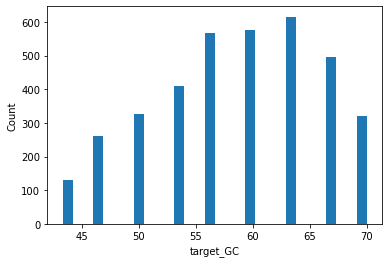

In [38]:
# Filter GC cotent and plot the GC content after filtering
filters.filter_probe_dict_by_metric(probe_dict, 'target_GC', lower_bound=43, upper_bound=73)
plot.plot_hist(probe_dict, column_key='target_GC')

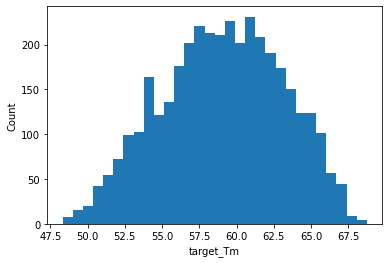

In [39]:
# Calculate and plot the melting-temperatures (Tm)
filters.calc_tm_for_probe_dict(probe_dict, Na_conc=390, fmd_percentile=30, probe_conc=5,
                              column_key_seq='target_sequence', column_key_write='target_Tm')
plot.plot_hist(probe_dict, column_key='target_Tm')

Krt5
	ENSMUST00000023709.7: 1869 / 2001 probes passed the filter 52 < target_Tm <  inf.
Aire
	ENSMUST00000145975.8: 1668 / 1702 probes passed the filter 52 < target_Tm <  inf.


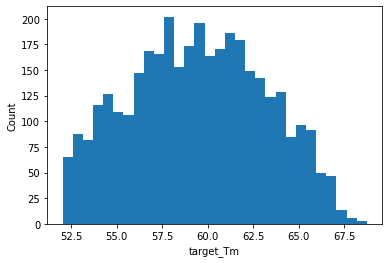

In [40]:
# Filter by Tm
# NOTE: here we used a higher upper bound for GC content and Tm than JM's original
# cutoffs. It was shown that higher Tm gives better signal-to-noise ratios in SM-FISH
filters.filter_probe_dict_by_metric(probe_dict, 'target_Tm', lower_bound=52)
plot.plot_hist(probe_dict, column_key='target_Tm')

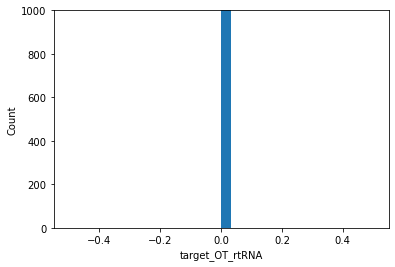

Krt5
	ENSMUST00000023709.7: 1869 / 1869 probes passed the filter -inf < target_OT_rtRNA <  0.5.
Aire
	ENSMUST00000145975.8: 1668 / 1668 probes passed the filter -inf < target_OT_rtRNA <  0.5.


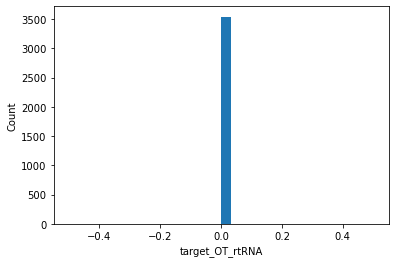

In [41]:
# Calculate and plot the off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_sequence', 'target_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_OT_rtRNA', y_max=1000)
# Filter out probes that have any rRNA/tRNA off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_OT_rtRNA')

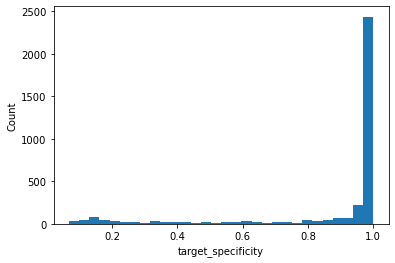

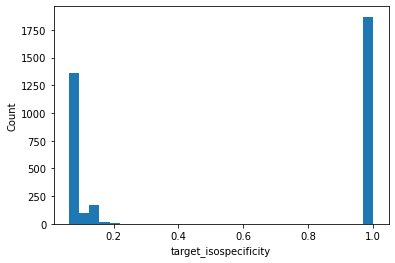

In [42]:
# Get the FPKMs of the transcripts
transcript_fpkms = dict(zip(list(transcriptome['transcript_id']), list(transcriptome['FPKM'])))

# Calculate the specificities and isoform specificities of the target regions
ot.calc_specificity(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms,
                    'target_sequence', 'target_specificity', 'target_isospecificity', 17)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

Krt5
	ENSMUST00000023709.7: 852 / 1869 probes passed the filter 0.99999 < target_specificity <  inf.
Aire
	ENSMUST00000145975.8: 1327 / 1668 probes passed the filter 0.99999 < target_specificity <  inf.


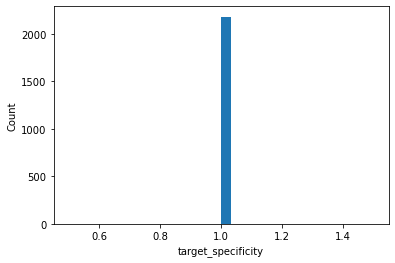

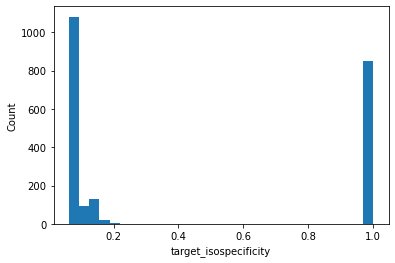

In [43]:
# Filter the specificities of the target regions
# Here we allow the probes to target other isoforms
# Don't allow any gene-level off-targets
filters.filter_probe_dict_by_metric(probe_dict, 'target_specificity', lower_bound=0.99999)
#filters.filter_probe_dict_by_metric(probe_dict, 'target_isospecificity', upper_bound=0.1)

plot.plot_hist(probe_dict, 'target_specificity')
plot.plot_hist(probe_dict, 'target_isospecificity')

# Design readout sequences

In [46]:
# Load the readout sequences into a data frame
readout_seqs = fio.load_fasta_into_df(readout_fasta_file)
rs.append_on_bit_ids_to_readout_sequences(readout_seqs, bit_names)
readout_seqs

,id,description,sequence,on-bit
0,RS0015,RS0015,ATCCTCCTTCAATACATCCC,0
1,RS0083,RS0083,ACACTACCACCATTTCCTAT,1
2,RS0095,RS0095,ACTCCACTACTACTCACTCT,2
3,RS0109,RS0109,ACCCTCTAACTTCCATCACA,3


In [47]:
import importlib
importlib.reload(rs)

# Add the readout sequences. Here we randomly add 2 readout sequences to each probe.
# Add an "T" between the concatenated sequences.
# Force each probe to have the same readout sequence
rs.add_readout_seqs_to_probes_random(probe_dict, readout_seqs, barcode_table, 2, 
                                     spacer='A', gene_id_key='name', each_probe_1_on_bit=True)

In [45]:
probe_dict['Aire'].keys()

dict_keys(['ENSMUST00000145975.8'])

probe_dict['Krt5']['ENSMUST00000023709.7']

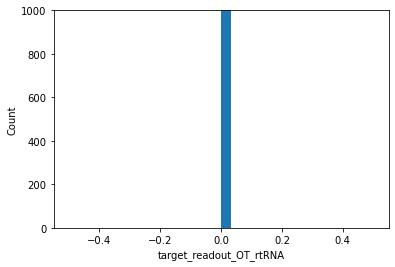

Krt5
	ENSMUST00000023709.7: 852 / 852 probes passed the filter -inf < target_readout_OT_rtRNA <  0.5.
Aire
	ENSMUST00000145975.8: 1327 / 1327 probes passed the filter -inf < target_readout_OT_rtRNA <  0.5.


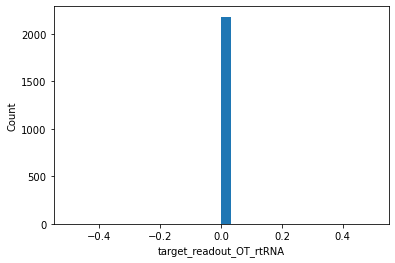

In [48]:
# Filter out probes that have off-targets to rRNA/tRNAs
ot.calc_OTs(probe_dict, ottable_rtRNAs, 'target_readout_sequence', 'target_readout_OT_rtRNA', 15)
plot.plot_hist(probe_dict, 'target_readout_OT_rtRNA', y_max=1000)
filters.filter_probe_dict_by_metric(probe_dict, 'target_readout_OT_rtRNA', upper_bound=0.5)
plot.plot_hist(probe_dict, 'target_readout_OT_rtRNA')

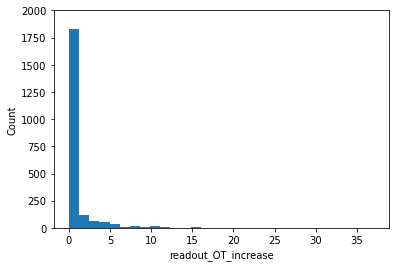

In [49]:
# Calculate how many more off-targets to the transcriptome are introduced due to the readout sequences.
# The off-target counts are weighted down by the FPKMs of the on-target transcripts
ot.calc_OT_diffs(probe_dict, ottable_transcriptome, gene_ottable_dict, transcript_fpkms, 
                 'target_sequence', 'target_readout_sequence', 'readout_OT_increase', 17)
plot.plot_hist(probe_dict, 'readout_OT_increase', y_max=2000)

In [51]:
import numpy as np
np.unique(probe_dict['Aire']['ENSMUST00000145975.8']['probe_barcode'], return_counts=True)

(array(['0100', '1000'], dtype=object), array([645, 682], dtype=int64))

Krt5
	ENSMUST00000023709.7: 683 / 852 probes passed the filter -inf < readout_OT_increase <  0.5.
Aire
	ENSMUST00000145975.8: 1008 / 1327 probes passed the filter -inf < readout_OT_increase <  0.5.


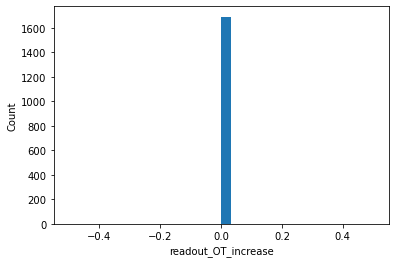

In [52]:
# Filter out the probes with extra off-targets due to the readouts
# Require the new weighted off-targets to be minor compared to the on-target weight.
filters.filter_probe_dict_by_metric(probe_dict, 'readout_OT_increase', upper_bound=0.5)
plot.plot_hist(probe_dict, 'readout_OT_increase')

In [53]:
np.unique(probe_dict['Aire']['ENSMUST00000145975.8']['probe_barcode'], return_counts=True)

(array(['0100', '1000'], dtype=object), array([503, 505], dtype=int64))

# Select probes

In [54]:
%%time
# Select probes by a stochastic greedy algorithms that optimizes the on-bit coverage
# and minimizes the overlapping between probes.
ps.select_probes_greedy_stochastic(probe_dict, N_probes_per_transcript=48, 
                                   N_on_bits=2)

Wall time: 26.3 s


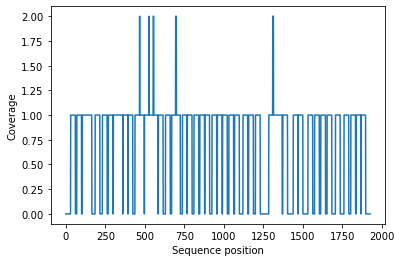

In [55]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENSMUST00000145975.8'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['Aire']['ENSMUST00000145975.8'], seq_len)

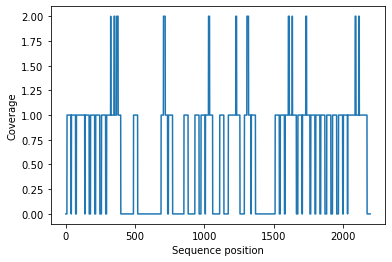

In [56]:
# Let's plot the probe coverage of an example transcript
seq_len = len(transcriptome[transcriptome['transcript_id'] == 'ENSMUST00000023709.7'].iloc[0]['sequence'])
plot.plot_sequence_coverage(probe_dict['Krt5']['ENSMUST00000023709.7'], seq_len)

In [57]:
probe_dict['Aire']['ENSMUST00000145975.8']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_OT_rtRNA,readout_OT_increase
438,Aire,ENSMUST00000145975.8,438,AGACCCCCCACCAAGAGAAAAGCACTGGAG,56.666667,58.588534,0,1.0,0.076923,RS0083::RS0083,0100,ACACTACCACCATTTCCTATAAGACCCCCCACCAAGAGAAAAGCAC...,0,0.0
1157,Aire,ENSMUST00000145975.8,1157,ACTGAGGTCAGCTTCAGAGAAAACCAGGGG,53.333333,55.851999,0,1.0,0.142857,RS0015::RS0015,1000,ATCCTCCTTCAATACATCCCAACTGAGGTCAGCTTCAGAGAAAACC...,0,0.0
880,Aire,ENSMUST00000145975.8,880,GTGGGGTTCCTCCCCTTCCATCCCTCCCCA,66.666667,65.731167,0,1.0,0.071429,RS0015::RS0015,1000,ATCCTCCTTCAATACATCCCAGTGGGGTTCCTCCCCTTCCATCCCT...,0,0.0
1032,Aire,ENSMUST00000145975.8,1032,CAGGAGATCCCCAGTGGCCTCTGGAGATGC,63.333333,59.882203,0,1.0,0.062500,RS0083::RS0083,0100,ACACTACCACCATTTCCTATACAGGAGATCCCCAGTGGCCTCTGGA...,0,0.0
331,Aire,ENSMUST00000145975.8,331,GCCGCCTGCATAGCATCCTGGACGGCTTCC,66.666667,62.781692,0,1.0,0.076923,RS0083::RS0083,0100,ACACTACCACCATTTCCTATAGCCGCCTGCATAGCATCCTGGACGG...,0,0.0
1706,Aire,ENSMUST00000145975.8,1706,ACAGGTGGCCCAGGAAGGGGTGGGCAGCAC,70.000000,67.051372,0,1.0,0.071429,RS0015::RS0015,1000,ATCCTCCTTCAATACATCCCAACAGGTGGCCCAGGAAGGGGTGGGC...,0,0.0
848,Aire,ENSMUST00000145975.8,848,GGGTAGAGATGAGCAGAAAGTGGGCCAGCA,56.666667,58.042737,0,1.0,0.082575,RS0083::RS0083,0100,ACACTACCACCATTTCCTATAGGGTAGAGATGAGCAGAAAGTGGGC...,0,0.0
586,Aire,ENSMUST00000145975.8,586,CTCTTGGAAACGGAATTCAGACCATGGCAG,50.000000,53.574223,0,1.0,0.075746,RS0015::RS0015,1000,ATCCTCCTTCAATACATCCCACTCTTGGAAACGGAATTCAGACCAT...,0,0.0
1068,Aire,ENSMUST00000145975.8,1068,TGCCTCCAGGGCAGAGTCCAACAGAACCTG,60.000000,59.662242,0,1.0,0.062500,RS0083::RS0083,0100,ACACTACCACCATTTCCTATATGCCTCCAGGGCAGAGTCCAACAGA...,0,0.0
1803,Aire,ENSMUST00000145975.8,1803,TAGGACCAAGAGCTGGCAGGTTCTGGCCTG,60.000000,60.003786,0,1.0,0.071429,RS0015::RS0015,1000,ATCCTCCTTCAATACATCCCATAGGACCAAGAGCTGGCAGGTTCTG...,0,0.0


In [58]:
probe_dict['Krt5']['ENSMUST00000023709.7']

,gene_id,transcript_id,shift,target_sequence,target_GC,target_Tm,target_OT_rtRNA,target_specificity,target_isospecificity,readout_names,probe_barcode,target_readout_sequence,target_readout_OT_rtRNA,readout_OT_increase
77,Krt5,ENSMUST00000023709.7,77,CAGGAACCATCATGTCTCGCCAGTCCAGTG,56.666667,56.003705,0,1.0,1.0,RS0109::RS0109,0001,ACCCTCTAACTTCCATCACAACAGGAACCATCATGTCTCGCCAGTC...,0,0.0
179,Krt5,ENSMUST00000023709.7,179,GCTTCAGCTCGGTGTCCCGCAGTGGTGGTG,66.666667,61.729767,0,1.0,1.0,RS0095::RS0095,0010,ACTCCACTACTACTCACTCTAGCTTCAGCTCGGTGTCCCGCAGTGG...,0,0.0
1583,Krt5,ENSMUST00000023709.7,1583,GCAGCAGCATTGGTGTTGGCAGTGGCTTTG,56.666667,58.013265,0,1.0,1.0,RS0109::RS0109,0001,ACCCTCTAACTTCCATCACAAGCAGCAGCATTGGTGTTGGCAGTGG...,0,0.0
2003,Krt5,ENSMUST00000023709.7,2003,GCCTCCCCATGGCTCAGTTCTACATTTGTG,53.333333,55.842809,0,1.0,1.0,RS0095::RS0095,0010,ACTCCACTACTACTCACTCTAGCCTCCCCATGGCTCAGTTCTACAT...,0,0.0
2114,Krt5,ENSMUST00000023709.7,2114,CATCCCTACCCAGATACCCACCTAAATTCT,46.666667,54.114237,0,1.0,1.0,RS0095::RS0095,0010,ACTCCACTACTACTCACTCTACATCCCTACCCAGATACCCACCTAA...,0,0.0
1968,Krt5,ENSMUST00000023709.7,1968,TTTGGTTCCCGGAAGGGAACGAATCCCAAC,53.333333,58.301844,0,1.0,1.0,RS0109::RS0109,0001,ACCCTCTAACTTCCATCACAATTTGGTTCCCGGAAGGGAACGAATC...,0,0.0
41,Krt5,ENSMUST00000023709.7,41,CCTCCCCACCACCAGCGCCCAGTGTTCTTG,66.666667,63.120126,0,1.0,1.0,RS0109::RS0109,0001,ACCCTCTAACTTCCATCACAACCTCCCCACCACCAGCGCCCAGTGT...,0,0.0
1203,Krt5,ENSMUST00000023709.7,1203,CCTTCGAAACACCAAGCACGAGATCTCTGA,50.000000,53.176511,0,1.0,1.0,RS0095::RS0095,0010,ACTCCACTACTACTCACTCTACCTTCGAAACACCAAGCACGAGATC...,0,0.0
1111,Krt5,ENSMUST00000023709.7,1111,GACATTGCCAACCGCAGCCGAACAGAGGCT,60.000000,60.029776,0,1.0,1.0,RS0095::RS0095,0010,ACTCCACTACTACTCACTCTAGACATTGCCAACCGCAGCCGAACAG...,0,0.0
1925,Krt5,ENSMUST00000023709.7,1925,TCTGGAGAGTAGTCTAGACCATGCCTGCTG,53.333333,54.625826,0,1.0,1.0,RS0109::RS0109,0001,ACCCTCTAACTTCCATCACAATCTGGAGAGTAGTCTAGACCATGCC...,0,0.0


# Quality check

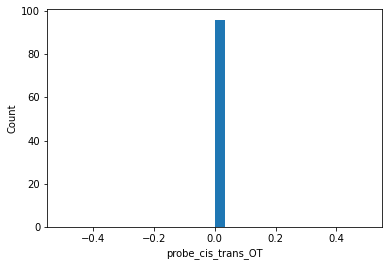

Wall time: 254 ms


In [59]:
%%time
# Filter out the probes that self complement or complement with other probes.

# Iterately remove the probes with high numbers of cis/trans-complementarity
# This filtering strategy is a compromise between speed and the number of probes to keep
while True:
    # Make a OTTable from the reverse-complement sequences of the probes.
    ottable_probes_rc = ot.get_OTTable_for_probe_dictionary(probe_dict, 'target_readout_sequence', 15, rc=True)
    
    # The off-targets in this table indicates cis/trans-complementarity
    ot.calc_OTs(probe_dict, ottable_probes_rc, 'target_readout_sequence', 'probe_cis_trans_OT', 15)
    max_ot = max(plot.get_values_from_probe_dict(probe_dict, 'probe_cis_trans_OT'))
    if max_ot == 0:
        break
    
    # Remove probes that have any cis/trans-complementarity
    filters.filter_probe_dict_by_metric(probe_dict, 'probe_cis_trans_OT', upper_bound=max_ot - 0.5)
    
plot.plot_hist(probe_dict, 'probe_cis_trans_OT')

In [61]:
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_sequence', 'target_readout_sequence_rc')

# Get a data frame of all probes
df_all_probes = p_d.probe_dict_to_df(probe_dict).sort_values(['probe_barcode', 'shift'])

# Make a column of probe names
probe_names = np.array(df_all_probes['gene_id']) + '_' + np.array(df_all_probes['transcript_id'])
probe_names = probe_names + '_shift:' + np.array(df_all_probes['shift']).astype(str)
probe_names = probe_names + '_GC:' + np.array(df_all_probes['target_GC']).astype('|S4').astype(str)
probe_names = probe_names + '_Tm:' + np.array(df_all_probes['target_Tm']).astype('|S4').astype(str)
probe_names = probe_names + '_specificity:' + np.array(df_all_probes['target_specificity']).astype('|S1').astype(str)
probe_names = probe_names + '_isospecificity:' + np.array(df_all_probes['target_isospecificity']).astype('|S4').astype(str)
probe_names = probe_names + '_' + np.array(df_all_probes['readout_names'])
df_all_probes['probe_names'] = probe_names

# Write the designed probes
df_all_probes.to_csv(probe_output_file, index=False)

In [64]:
# generate IDT list
well_positions = []
for _col in 'ABCDEFGH':
    for _row in range(12):
        well_positions.append(f"{_col}{_row+1}")

In [70]:
# export IDT format
# Get the reverse-complementary sequences of the designed probes
p_d.get_rc_sequences(probe_dict, 'target_readout_sequence', 'target_readout_sequence_rc')
# Get a data frame of all probes
idt_df = pd.DataFrame({
    'Well Position': well_positions,
    'Name': df_all_probes['probe_names'][:96],
    'Sequence': [_seq[-60:] for _seq in df_all_probes['target_readout_sequence_rc'][:96]],
})
# Write the designed probes
idt_probe_output_file = os.path.join(output_folder, r'idt_order.xlsx')

idt_df.to_excel(idt_probe_output_file, index=False)

In [66]:

idt_df

,Well Position,Name,Sequence
14,A1,Krt5_ENSMUST00000023709.7_shift:9_GC:66.6_Tm:6...,TAGAGGGTTCTGGCGAGGTCAGCGGCGTTCAACAGGACGTTGTGAT...
6,A2,Krt5_ENSMUST00000023709.7_shift:41_GC:66.6_Tm:...,TAGAGGGTTCAAGAACACTGGGCGCTGGTGGTGGGGAGGTTGTGAT...
0,A3,Krt5_ENSMUST00000023709.7_shift:77_GC:56.6_Tm:...,TAGAGGGTTCACTGGACTGGCGAGACATGATGGTTCCTGTTGTGAT...
23,A4,Krt5_ENSMUST00000023709.7_shift:139_GC:66.6_Tm...,TAGAGGGTTGACAGATGGGGTGATGGCAGAGGCGGCGCTTTGTGAT...
28,A5,Krt5_ENSMUST00000023709.7_shift:295_GC:56.6_Tm...,TAGAGGGTTGCTGCCTCCGCCAGAACTGTAGGATATCCTTTGTGAT...
...,...,...,...
71,H8,Aire_ENSMUST00000145975.8_shift:1653_GC:66.6_T...,AGGAGGATTCTCGGCCAGCGGGCGTGACATGCTCTGGATTGGGATG...
53,H9,Aire_ENSMUST00000145975.8_shift:1706_GC:70.0_T...,AGGAGGATTGTGCTGCCCACCCCTTCCTGGGCCACCTGTTGGGATG...
86,H10,Aire_ENSMUST00000145975.8_shift:1760_GC:56.6_T...,AGGAGGATTTCTCAGAACAGAGTGCCTCATCCGATGGGGTGGGATG...
57,H11,Aire_ENSMUST00000145975.8_shift:1803_GC:60.0_T...,AGGAGGATTCAGGCCAGAACCTGCCAGCTCTTGGTCCTATGGGATG...
